### Connect to Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

In [2]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [3]:
!pip install keras-tuner -q
import tensorflow as tf
import keras_tuner
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [4]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = '../input/homework1/training_data_final'

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

numbers = [186,
           532,
           515,
           511,
           531,
           222,
           537,
           508,
]

# Weight classes
class_weights = {}
class_mean = sum(numbers) / len(numbers)
for i, n in enumerate(numbers):
    class_weights[i] = (1 / n) * class_mean

print(class_weights)

{0: 2.3803763440860215, 1: 0.8322368421052632, 2: 0.8597087378640776, 3: 0.8664383561643835, 4: 0.833804143126177, 5: 1.9943693693693694, 6: 0.824487895716946, 7: 0.8715551181102362}


In [7]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 96

In [8]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    class_names=labels,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    interpolation='nearest',
    validation_split=0.2,
    subset='training'
)

valid_gen = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    class_names=labels,
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    interpolation='nearest',
    validation_split=0.2,
    subset='validation'
)

tg = list(train_gen.unbatch().map(lambda x, y: (x, y)))
vg = list(valid_gen.unbatch().map(lambda x, y: (x, y)))

x_train = np.asarray(list(map(lambda t: t[0], tg)))
y_train = np.asarray(list(map(lambda t: t[1], tg)))

x_val = np.asarray(list(map(lambda t: t[0], vg)))
y_val = np.asarray(list(map(lambda t: t[1],vg)))

Found 3542 files belonging to 8 classes.
Using 2834 files for training.


2022-11-20 17:20:42.138487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 17:20:42.245354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 17:20:42.246162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 17:20:42.249227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3542 files belonging to 8 classes.
Using 708 files for validation.


2022-11-20 17:20:45.306171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Models metadata

In [9]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [11]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# Use the supernet as feature extractor
supernet.trainable = False

#supernet.summary()
#tfk.utils.plot_model(supernet)

80150528/80134624 [==============================] - 1s 0us/step


In [12]:
def build_model(hp):
    model = tfk.Sequential()
    
    model.add(tfk.Input(shape=input_shape))
    model.add(tf.keras.layers.Lambda(tf.keras.applications.vgg19.preprocess_input))
    
    model.add(supernet)
    
    model.add(tfkl.GlobalAveragePooling2D(name='GAP'))
    
    for i in range(hp.Int("num_layers", 1, 5)):
        if hp.Boolean(f"dropout_{i}"):
            model.add(tfkl.Dropout(rate=hp.Float(f"droprate_{i}",min_value=0.1,max_value=0.5, step=0.1)))
        model.add(
            tfkl.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        
    if hp.Boolean("dropout"):
        model.add(tfkl.Dropout(rate=hp.Float('droprate',min_value=0.1,max_value=0.5)))
        
    model.add(
        tfkl.Dense(
            8, 
            activation='softmax',
            kernel_initializer = tfk.initializers.GlorotUniform(seed)
        )
    )

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [13]:
# Might also use keras_tuner.BayesianOptimization
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10, # Number of configurations to try
    executions_per_trial=2,
    overwrite=True,
    directory="/kaggle/working",
    project_name="homework1",
)

In [14]:
tuner.search(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Trial 10 Complete [00h 02m 07s]
val_accuracy: 0.6186440587043762

Best val_accuracy So Far: 0.6701977252960205
Total elapsed time: 00h 22m 10s


In [15]:
best_hps = tuner.get_best_hyperparameters(5)
tl_model = build_model(best_hps[0])
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 448)               229824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                28736     
_________________________________________________________________
dense_5 (Dense)              (None, 352)              

In [16]:
# Train the model
history = tl_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
    class_weight=class_weights
).history

Epoch 1/200
89/89 [==============================] - 3s 26ms/step - loss: 1.5694 - accuracy: 0.4397 - val_loss: 1.2770 - val_accuracy: 0.5042
Epoch 2/200
89/89 [==============================] - 2s 23ms/step - loss: 1.1213 - accuracy: 0.5974 - val_loss: 1.1539 - val_accuracy: 0.5607
Epoch 3/200
89/89 [==============================] - 2s 23ms/step - loss: 0.9185 - accuracy: 0.6803 - val_loss: 1.0405 - val_accuracy: 0.6102
Epoch 4/200
89/89 [==============================] - 2s 23ms/step - loss: 0.7703 - accuracy: 0.7343 - val_loss: 1.0070 - val_accuracy: 0.6342
Epoch 5/200
89/89 [==============================] - 2s 23ms/step - loss: 0.6358 - accuracy: 0.7809 - val_loss: 1.0003 - val_accuracy: 0.6356
Epoch 6/200
89/89 [==============================] - 2s 23ms/step - loss: 0.5375 - accuracy: 0.8278 - val_loss: 1.0173 - val_accuracy: 0.6356
Epoch 7/200
89/89 [==============================] - 2s 23ms/step - loss: 0.4237 - accuracy: 0.8596 - val_loss: 1.0130 - val_accuracy: 0.6469
Epoch 

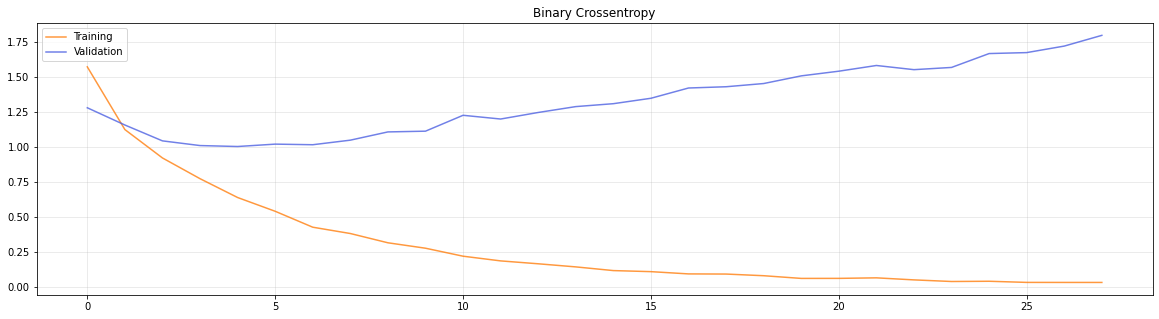

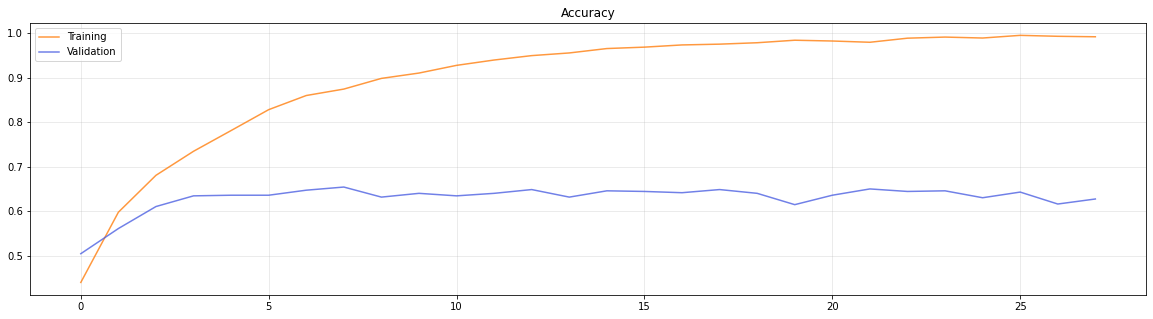

In [17]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save('ANN_Homework1_Model')

2022-11-20 17:51:53.153815: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
# Set all VGG layers to True
tl_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [20]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 512)               0         
____________________________________________________________

In [21]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [22]:
# Fine-tune the model
ft_history = tl_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = 64,
    epochs = 200,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    class_weight=class_weights,
).history

Epoch 1/200
45/45 [==============================] - 6s 61ms/step - loss: 1.7143 - accuracy: 0.4379 - val_loss: 1.2734 - val_accuracy: 0.5127
Epoch 2/200
45/45 [==============================] - 2s 54ms/step - loss: 1.3364 - accuracy: 0.5176 - val_loss: 1.3954 - val_accuracy: 0.4859
Epoch 3/200
45/45 [==============================] - 2s 54ms/step - loss: 1.3136 - accuracy: 0.5116 - val_loss: 1.2807 - val_accuracy: 0.4873
Epoch 4/200
45/45 [==============================] - 2s 53ms/step - loss: 1.3562 - accuracy: 0.5236 - val_loss: 1.2602 - val_accuracy: 0.5254
Epoch 5/200
45/45 [==============================] - 2s 53ms/step - loss: 1.3559 - accuracy: 0.5046 - val_loss: 1.3285 - val_accuracy: 0.5056
Epoch 6/200
45/45 [==============================] - 2s 55ms/step - loss: 1.1086 - accuracy: 0.6076 - val_loss: 1.1251 - val_accuracy: 0.6130
Epoch 7/200
45/45 [==============================] - 2s 54ms/step - loss: 1.0714 - accuracy: 0.6154 - val_loss: 1.1302 - val_accuracy: 0.5904
Epoch 

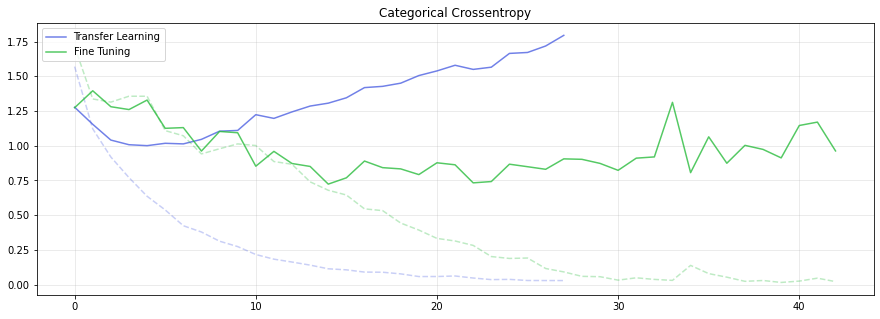

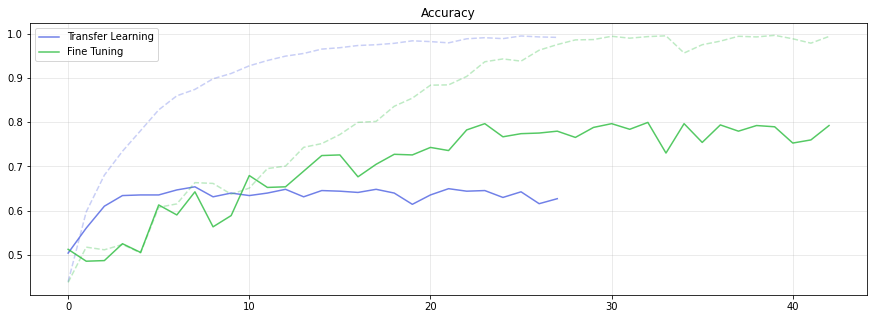

In [25]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [26]:
from sklearn.metrics import classification_report

def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    for sample in validation_dataset:
        for i in range(len(sample[0])):
            data_list.append(sample[0][i])
            label_list.append(sample[1][i])

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = tl_model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

In [35]:
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.batch(BATCH_SIZE)
    .prefetch(AUTO)
)
evaluate_classes_performance(tl_model, val_ds)

              precision    recall  f1-score   support

           0       0.48      0.39      0.43        33
           1       0.76      0.91      0.83        97
           2       0.82      0.90      0.86       113
           3       0.92      0.69      0.79       101
           4       0.75      0.83      0.79        93
           5       0.77      0.85      0.80        39
           6       0.91      0.90      0.91       119
           7       0.75      0.67      0.71       113

    accuracy                           0.80       708
   macro avg       0.77      0.77      0.76       708
weighted avg       0.80      0.80      0.80       708



In [36]:
import shutil
tl_model.save('ANN_Homework1_Model')
shutil.make_archive("ANN_Homework1_Model", 'zip', '/kaggle/working/ANN_Homework1_Model')

'/kaggle/working/ANN_Homework1_Model.zip'